# Detecção de Animais

## Import librarys


In [6]:
import matplotlib
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers import Dense
from keras import backend as K
from keras.optimizers import SGD
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import os
import cv2

## Carregando imagens


In [7]:
data = []
labels= []

# Embaralhar as imagens
imagePaths = sorted(list(paths.list_images("/home/matheusjerico/Documentos/DSA/05. MachineLearning/Cap-12-IntroduçãoDeepLearning/keras-tutorial/animals")))
random.seed(42)
random.shuffle(imagePaths)

for imagePath in imagePaths:
    # carrega a imagem, redimensiona em 64x64,
    # coloca na lista
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (128, 128))
    data.append(image)
    
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)


In [8]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

## Normalizando os dados em um range de [0,1]


## Separando o dataset em treino e teste

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=42)

## Transformando labels (y) que é string em vetor binario

- 'fit_transform' localiza todos os rótulos de classe exclusivos em 'y_train' e, em seguida, os transforma em rótulos codificados de um único clique.

- Uma chamada de apenas '.transform' em y_test executa apenas a etapa de codificação única: o conjunto exclusivo de rótulos de classe possíveis já foi determinado pela chamada para '.fit_transform.'

In [10]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train) 
y_test = lb.transform(y_test) 

In [11]:
# Note que só um elemento do vetor tem valor 1, por isso é chamado de "one-hot"
y_train[0]

array([0, 1, 0])

## Construindo geração de imagem para aumentar os dados

In [12]:
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode='nearest')
valAug = ImageDataGenerator()

## Criando Modelo

In [13]:
print("Classes transformadas pelo 'lb': %d" %(len(lb.classes_)))

Classes transformadas pelo 'lb': 3


In [16]:
# Criando modelo
model = Sequential()

# Inicializa o inputShape para "channels_last" (padrão TensorFlor)
inputShape = (128, 128, 3) # pixels e profundidade (RGB tem profundidade 3)
chanDim = -1

# Se o keras tiver usando o "channels_first" (padrão Theano), atualiza o inputShape e channels dimension
if K.image_data_format() == "channels_first":
    inputShape = (3, 128, 128) # profundidade e pixels
    chanDim = 1

## BatchNormalization: é usada para normalizar as ativações de um determinado volume de entrada
## antes de passá-lo para a próxima camada na rede. 
## Provou-se ser muito eficaz na redução do número de "epochs" necessárias para treinar uma CNN,
## bem como estabilizar o treinamento em si.

## MaxPooling2d: usado para redução do tamanho espacial, 
## é colocado entre as consecutivas CONV layers

## Dropout: processo para reduzir o overfitting, aumentar a accuracy e generalizar o modelo
## Como denotado pelo parâmetro, 25% das conexões do node são desconectadas aleatoriamente (drop out)
## entre as camadas durante cada iteração de treinamento.

# CONV => RELU => POOL layers set
model.add(Conv2D(32, (3,3), padding="same", input_shape=inputShape))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 2 => POOL
model.add(Conv2D(64,(3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64,(3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# (CONV => RELU) * 3 => POOL
model.add(Conv2D(128,(3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128,(3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128,(3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# FC => RELU
model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Softmax classifier - Layer output
model.add(Dense(len(lb.classes_)))
model.add(Activation('softmax'))


## Compilar Modelo

In [17]:
from keras.optimizers import Adam
INIT_LR = 0.01
EPOCHS = 75
BS = 32

# Compilar o modelo usando SGD para otimização
# Para perdas usando categorical_crossentropy (quando tem apenas duas classes em 'y' usar binary_crossentropy))
opt=SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
opt_1 = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt_1,
              metrics=['accuracy'])

## Treinando o modelo


In [19]:
## Como estamos realizando o aumento de dados, chamamos 'model.fit_generator' (em vez de model.fit).
## Devemos passar o gerador com nossos dados de treinamento como o primeiro parâmetro.
## O gerador produzirá lotes de dados de treinamento aumentados de acordo com as
## configurações feitas anteriormente.

H = model.fit_generator(
                        aug.flow(x_train, y_train, batch_size=BS),
                        steps_per_epoch=len(x_train) // BS,
                        validation_data=valAug.flow(x_test, y_test),
                        validation_steps=len(x_test) // BS,
                        epochs=EPOCHS)

Epoch 1/75
70/70 [==============================] - 356s 5s/step - loss: 0.9706 - acc: 0.6112 - val_loss: 0.8593 - val_acc: 0.6562
Epoch 2/75
70/70 [==============================] - 343s 5s/step - loss: 0.8859 - acc: 0.6305 - val_loss: 0.8273 - val_acc: 0.6825
Epoch 3/75
70/70 [==============================] - 343s 5s/step - loss: 0.8588 - acc: 0.6439 - val_loss: 1.3576 - val_acc: 0.6504
Epoch 4/75
70/70 [==============================] - 343s 5s/step - loss: 0.8639 - acc: 0.6451 - val_loss: 0.8219 - val_acc: 0.7075
Epoch 5/75
70/70 [==============================] - 343s 5s/step - loss: 0.7788 - acc: 0.6792 - val_loss: 0.8346 - val_acc: 0.6685
Epoch 6/75
70/70 [==============================] - 353s 5s/step - loss: 0.7518 - acc: 0.6789 - val_loss: 0.6834 - val_acc: 0.7089
Epoch 7/75
70/70 [==============================] - 368s 5s/step - loss: 0.7421 - acc: 0.6807 - val_loss: 0.7193 - val_acc: 0.7145
Epoch 8/75
70/70 [==============================] - 367s 5s/step - loss: 0.7334 - a

## Avaliando o Modelo

In [20]:
pred = model.predict(x_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1),
                            pred.argmax(axis=1), target_names=lb.classes_))


              precision    recall  f1-score   support

        cats       0.71      0.83      0.77       236
        dogs       0.78      0.66      0.72       236
       panda       0.95      0.94      0.94       278

    accuracy                           0.82       750
   macro avg       0.81      0.81      0.81       750
weighted avg       0.82      0.82      0.82       750



## Plotando loss x accuracy

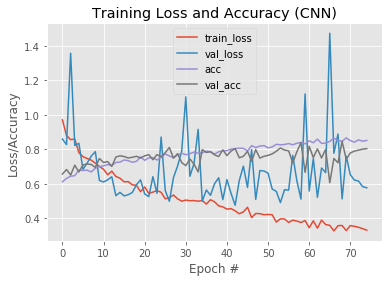

In [21]:
N=np.arange(0,EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['acc'], label='acc')
plt.plot(N, H.history['val_acc'], label='val_acc')
plt.title("Training Loss and Accuracy (CNN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

## Predição com novo Dado

In [27]:
# Carregando imagem
new_image = cv2.imread("/home/matheusjerico/Documentos/DSA/05. MachineLearning/Cap-12-IntroduçãoDeepLearning/keras-tutorial/images/dog.jpg")
output = image.copy()

# Redimensionando
new_image = cv2.resize(new_image, (128, 128))

# Normalizando os dados no range[0,1]
new_image = new_image.astype("float32") / 255.0

# Como é uma CNN, é necessário colcoar a dimensão da imagem
new_image = new_image.reshape(1, new_image.shape[0], new_image.shape[1], new_image.shape[2])

In [28]:
preds = model.predict(new_image)
print(preds)
i = preds.argmax(axis=1)[0] # retorna o index que tem o maior valor
print(i)
label = lb.classes_[i] # extrai a string 'do animal' que é a que possui index (label binarizer)
print(label)


[[6.6218324e-02 9.3321425e-01 5.6737656e-04]]
1
dogs


In [29]:
# Apresentando resultado
text="{}: {:.2f}f".format(label, preds[0][i]*100)
cv2.putText(output, text, (10,30),cv2.FONT_HERSHEY_SIMPLEX,0.7,
            (0, 0, 255),2)

cv2.imshow("Image",output)
cv2.waitKey(0)

113